# Craft different analysis

reference:

[1] https://www.yuque.com/xjh2000/cipher-paper/kyz6oiott1am9gb5?singleDoc# 《Related-key Differential Cryptanalysis of Full
Round CRAFT》

In [24]:
Sbox = [0xC, 0xA, 0xD, 0x3, 0xE, 0xB, 0xF, 0x7, 0x8, 0x9, 0x1, 0x5, 0x0, 0x2, 0x4, 0x6]


Permutation = [15, 12, 13, 14, 10, 9, 8, 11, 6, 5, 4, 7, 1, 2, 3, 0]


def encrypt(plaintext: list, key0: list, key1: list) -> list:
    state = [plaintext[i] for i in range(len(plaintext))]

    for i in range(31):
        # MixColumns
        for i in range(4):
            state[i] = state[i] ^ state[i + 8] ^ state[i + 12]
            state[i + 4] = state[i + 4] ^ state[i + 12]
        # AddRoundKey
        if i % 2 == 0:
            state = [state[j] ^ key0[j] for j in range(len(state))]
        else:
            state = [state[j] ^ key1[j] for j in range(len(state))]
        # Permutation
        state = [state[Permutation[j]] for j in range(len(state))]
        # Sbox
        state = [Sbox[state[j]] for j in range(len(state))]
    # Last round
    for i in range(4):
        state[i] = state[i] ^ state[i + 8] ^ state[i + 12]
        state[i + 4] = state[i + 4] ^ state[i + 12]
    state = [state[j] ^ key0[j] for j in range(len(state))]
    return state

In [25]:
import random


key0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
key0_diff = [0 ^ 4, 1, 2, 3, 4 ^ 4, 5, 6, 7, 8, 9, 10, 11, 12 ^ 4, 13, 14, 15]
key1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
key1_diff = [0, 1 ^ 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

plaintexts = [[random.randint(0, 0xF) for _ in range(16)] for _ in range(1600000)]

plaintexts_diff = list(
    map(
        lambda plaintext: [
            plaintext[i] if i != 12 else plaintext[i] ^ 0x4
            for i in range(len(plaintext))
        ],
        plaintexts,
    )
)

ciphertexts = [encrypt(plaintexts[i], key0, key1) for i in range(len(plaintexts))]

ciphertexts_diff = [encrypt(plaintexts_diff[i], key0_diff, key1_diff) for i in range(len(plaintexts_diff))]

In [26]:
def is_different_expression(ciphertext: list, ciphertext_diff: list, guessKey):
    diff15 = ciphertext[15] ^ ciphertext_diff[15]
    diff10 = ciphertext[10] ^ ciphertext_diff[10]
    diff7 = ciphertext[7] ^ ciphertext_diff[7]
    diff3 = ciphertext[3] ^ ciphertext_diff[3]
    diff2 = ciphertext[2] ^ ciphertext_diff[2]
    diff1 = ciphertext[1] ^ ciphertext_diff[1] ^ 0x2

    limit = [0x1, 0x4, 0x7, 0x9, 0xA, 0xC]
    if diff15 != diff7 or diff15 != diff3 or diff10 != diff2:
        return False
    if (
        diff1 not in limit
        or diff2 not in limit
        or diff3 not in limit
        or diff7 not in limit
        or diff10 not in limit
        or diff15 not in limit
    ):
        return False
    # backware through diff characteristic
    c15 = ciphertext[15] ^ guessKey
    cd15 = ciphertext_diff[15] ^ guessKey
    c15 = Sbox[c15]
    cd15 = Sbox[cd15]

    if c15 ^ cd15 == 0x5:
        return True
    return False

In [28]:
counts = [0 for _ in range(16)]

for i in range(1600000):
    for j in range(16):
        if is_different_expression(ciphertexts[i], ciphertexts_diff[i], j):
            counts[j] += 1

In [29]:
import numpy as np

counts = np.array(counts)

# Find the index of the maximum count
index = np.unravel_index(np.argmax(counts, axis=None), counts.shape)

print(index) 

(15,)


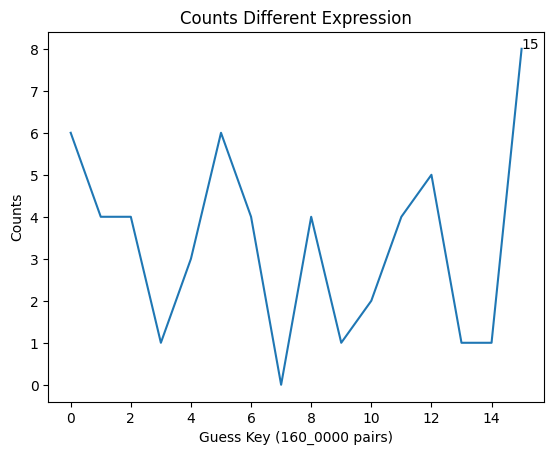

In [31]:
import matplotlib.pyplot as plt

flat_probility = counts.flatten()

# Find the index of the maximum probability
max_index = np.argmax(flat_probility)

plt.plot(flat_probility)
plt.xlabel('Guess Key (160_0000 pairs)')
plt.ylabel('Counts')
plt.title('Counts Different Expression')

# Annotate the maximum point
plt.annotate(f'{max_index}', xy=(float(max_index), flat_probility[max_index]), xytext=(float(max_index), flat_probility[max_index] ))

plt.show()